# import essential packages

In [99]:

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [100]:
from geopy.geocoders import Nominatim
import folium

# Url for extracting data

In [101]:
url=requests.get('https://en.wikipedia.org/wiki/List_of_cities_in_Andhra_Pradesh_by_population').text

In [102]:
soup=BeautifulSoup(url,'lxml')

In [103]:
#soup

In [163]:
table=soup.find('table',{'class':'sortable wikitable'})
#table

In [157]:
links=table.findAll('a')
#links

In [158]:
cities=[]
for link in links:
    cities.append(link.get('title'))
#cities

In [107]:
type(cities[10])

NoneType

In [112]:
for i in cities:
    if i==None:
        cities.remove(i)
    elif 'district' in i:
        cities.remove(i)
        

In [159]:
#cities

In [114]:
del cities[4]
df=pd.DataFrame()
df['cities']=cities

In [160]:
#df

In [116]:
def get_coords_local(cities, output_as='center'):
    # create url
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search.php?q=',
                             cities+', Andhra Pradesh',
                             '&format=json&polygon=0')
    response = requests.get(url).json()[0]

    # parse response to list
    if output_as == 'boundingbox':
        lst = response[output_as]
        output = [float(i) for i in lst]
    if output_as == 'center':
        lst = [response.get(key) for key in ['lat','lon']]
        output = [float(i) for i in lst]
    return output

In [161]:
df2 = df.copy()

latitudeCln = []
longitudeCln = []
for index, row in df2.iterrows():
    #print(row[0])
    lat, long = get_coords_local(cities=row[0], output_as='center')
    latitudeCln.append(lat)
    longitudeCln.append(long)

df2['Latitude'] = latitudeCln
df2['Longitude'] = longitudeCln

df2.shape

(32, 3)

# Geeting the Geo coordinates

In [119]:
address = 'Andhra Pradesh, India'

geolocator = Nominatim(user_agent="capstoneProject")
location = geolocator.geocode(address, timeout=60, exactly_one=True)
latitude = location.latitude
longitude = location.longitude
print('The decimal coordinates of Andhra Pradesh are {}, {}.'.format(latitude, longitude))

The decimal coordinates of Andhra Pradesh are 15.9240905, 80.1863809.


In [120]:
df3=df2.copy()

In [121]:
map_andhra = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, local in zip(df3['Latitude'], df3['Longitude'], df3['cities']):
    label = '{}'.format(local)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_andhra)  
    
map_andhra

In [150]:
map_andhra.save

<bound method Element.save of <folium.folium.Map object at 0x0000022882B13F28>>

In [122]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url1 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)

            if (categoryIds != ''):
                url1 = url1 + '&categoryId={}'
                url1 = url1.format(categoryIds)

            # make the GET request
            response = requests.get(url1).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['cities', 
                  'city Latitude', 
                  'city Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    except:
        print(url1)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

# Four square crendentials

In [123]:
limit = 500 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius
CLIENT_ID = '01F103TYTSZJEFE3LWWBNOXZPJRUZ4QWFUW33WY3BLLES0QP'
CLIENT_SECRET = 'DN5FCGXOCZCFS1ZQDPIZKRYPIIH0PTYMSK4DEODUEEMSPFKI'
VERSION = '20190705'

In [153]:
andhra_venues_malls = getNearbyVenues(names=df3['cities'], latitudes=df3['Latitude'], longitudes=df3['Longitude'], radius=10000, categoryIds='4bf58dd8d48988d180941735')
andhra_venues_malls.head()

,cities,city Latitude,city Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Visakhapatnam,17.723128,83.301284,Inox Chitralaya Mall,17.712356,83.301176,Multiplex
1,Visakhapatnam,17.723128,83.301284,Sangam Sarat,17.725549,83.326355,Multiplex
2,Visakhapatnam,17.723128,83.301284,Inox,17.734076,83.318304,Multiplex
3,Visakhapatnam,17.723128,83.301284,screen 4 varun inox,17.709473,83.312653,Multiplex
4,Visakhapatnam,17.723128,83.301284,Inox,17.711077,83.315785,Multiplex


In [125]:
andhra_venues_malls.shape

(67, 7)

In [126]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['cities'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [165]:
map_ap_malls = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(andhra_venues_malls, 'red', map_ap_malls)
#map_ap_malls

In [128]:
ap_venues_highschools = getNearbyVenues(names=df3['cities'], latitudes=df3['Latitude'], longitudes=df3['Longitude'], radius=20000, categoryIds='4bf58dd8d48988d13d941735')
ap_venues_highschools.head()

,cities,city Latitude,city Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Visakhapatnam,17.723128,83.301284,Pollocks School,17.726652,83.305002,High School
1,Visakhapatnam,17.723128,83.301284,Silver Oaks International School,17.785889,83.378420,High School
2,Visakhapatnam,17.723128,83.301284,Mother Theresa English Medium School,17.765557,83.225806,High School
3,Visakhapatnam,17.723128,83.301284,Ramanath Secondary School,17.747763,83.234585,High School
4,Visakhapatnam,17.723128,83.301284,All saints convent,17.720388,83.309760,High School


In [129]:
ap_venues_highschools.shape

(62, 7)

In [164]:
map_ap_highschools = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(ap_venues_highschools, 'green', map_ap_highschools)
#map_ap_highschools

In [131]:
ap_venues_uni = getNearbyVenues(names=df3['cities'], latitudes=df3['Latitude'], longitudes=df3['Longitude'], radius=10000, categoryIds='4bf58dd8d48988d1ae941735')
ap_venues_uni.head()

,cities,city Latitude,city Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Visakhapatnam,17.723128,83.301284,gitam,17.736346,83.309425,University
1,Visakhapatnam,17.723128,83.301284,GITAM University,17.781064,83.376782,University
2,Visakhapatnam,17.723128,83.301284,Dept. of Education,17.721780,83.320506,University
3,Visakhapatnam,17.723128,83.301284,Andhra University Delta Studies,17.737383,83.327916,University
4,Visakhapatnam,17.723128,83.301284,Andhra University Civil Department,17.687468,83.212322,University


In [132]:
ap_venues_uni.shape

(40, 7)

In [166]:
map_ap_uni = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(ap_venues_uni, 'black', map_ap_uni)
#map_ap_uni

In [134]:
ap_venues_office = getNearbyVenues(names=df3['cities'], latitudes=df3['Latitude'], longitudes=df3['Longitude'], radius=10000, categoryIds='4d4b7105d754a06375d81259')
ap_venues_office.head()

,cities,city Latitude,city Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Visakhapatnam,17.723128,83.301284,Divisional Railway Manager Office,17.724348,83.299380,Government Building
1,Visakhapatnam,17.723128,83.301284,Dwarakanagar,17.725860,83.306840,Parking
2,Visakhapatnam,17.723128,83.301284,Reliance Web World,17.726236,83.303430,Tech Startup
3,Visakhapatnam,17.723128,83.301284,Narasimha swamy temple,17.766856,83.249161,Temple
4,Visakhapatnam,17.723128,83.301284,Indus Hospitals,17.711569,83.302108,Hospital


In [135]:
ap_venues_office.shape

(715, 7)

In [167]:
map_ap_office = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(ap_venues_office, 'fuchsia', map_ap_office)
#map_ap_office

In [137]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('cities').count()
    
    for n in startDf['cities']:
        try:
            startDf.loc[startDf['cities'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['cities'] == n,columnTitle] = 0

In [138]:
df_data = df3.copy()
df_data.rename(columns={'cities':'cities'}, inplace=True)
addColumn(df_data, 'malls', andhra_venues_malls)
addColumn(df_data, 'high schools', ap_venues_highschools)
addColumn(df_data, 'universities', ap_venues_uni)
addColumn(df_data, 'offices', ap_venues_office)
df_data

,cities,Latitude,Longitude,malls,high schools,universities,offices
0,Visakhapatnam,17.723128,83.301284,11.0,14.0,12.0,49.0
1,Vijayawada,16.508759,80.618510,23.0,6.0,9.0,45.0
2,Guntur,16.291519,80.454159,6.0,6.0,3.0,46.0
3,Nellore,14.449372,79.987376,3.0,8.0,0.0,48.0
4,Kurnool,15.830925,78.042537,5.0,1.0,1.0,29.0
5,Rajahmundry,17.005045,81.780473,2.0,3.0,1.0,42.0
6,Kadapa,14.467149,78.822888,0.0,1.0,0.0,20.0
7,Kakinada,16.943738,82.235061,4.0,3.0,4.0,45.0
8,Tirupati,13.631637,79.423171,2.0,2.0,4.0,50.0
9,Eluru,16.710426,81.115382,2.0,0.0,0.0,44.0


In [139]:
import matplotlib.pyplot as plt
y=df_data[['malls','high schools','universities','offices']]
x=df_data['cities']

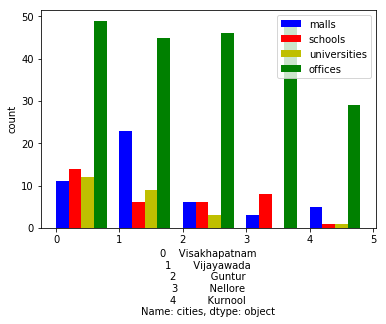

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# The data
malls = df_data['malls'].head()
highschools = df_data['high schools'].head()
universities=df_data['universities'].head()
offices=df_data['offices'].head()
indices = range(len(malls))
names = df_data['cities'].head()
# Calculate optimal width
width = np.min(np.diff(indices))/5.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices+width/2,malls,width,color='b',label='malls')
ax.bar(indices+width*3/2,highschools,width,color='r',label='schools')
ax.bar(indices+width*5/2,universities,width,color='y',label='universities')
ax.bar(indices+width*7/2,offices,width,color='g',label='offices')
ax.set_ylabel('count')
ax.set_xlabel(names)
ax.legend()
plt.show()

In [141]:
mall=-4
school=1
university=2
offices=3

In [142]:
df_weighted = df_data[['cities']].copy()

In [143]:
df_weighted['Score'] = df_data['malls'] * mall + df_data['high schools'] *school + df_data['universities'] * university + df_data['offices'] *offices
df_weighted = df_weighted.sort_values(by=['Score'], ascending=False)
df_weighted

,cities,Score
8,Tirupati,152.0
30,Amaravati (state capital),148.0
0,Visakhapatnam,141.0
3,Nellore,140.0
21,Bhimavaram,139.0
11,Vizianagaram,135.0
7,Kakinada,130.0
2,Guntur,126.0
9,Eluru,124.0
5,Rajahmundry,123.0


In [144]:
data=pd.merge(df_data,df_weighted, on='cities',how='outer')

In [145]:
data

,cities,Latitude,Longitude,malls,high schools,universities,offices,Score
0,Visakhapatnam,17.723128,83.301284,11.0,14.0,12.0,49.0,141.0
1,Vijayawada,16.508759,80.618510,23.0,6.0,9.0,45.0,67.0
2,Guntur,16.291519,80.454159,6.0,6.0,3.0,46.0,126.0
3,Nellore,14.449372,79.987376,3.0,8.0,0.0,48.0,140.0
4,Kurnool,15.830925,78.042537,5.0,1.0,1.0,29.0,70.0
5,Rajahmundry,17.005045,81.780473,2.0,3.0,1.0,42.0,123.0
6,Kadapa,14.467149,78.822888,0.0,1.0,0.0,20.0,61.0
7,Kakinada,16.943738,82.235061,4.0,3.0,4.0,45.0,130.0
8,Tirupati,13.631637,79.423171,2.0,2.0,4.0,50.0,152.0
9,Eluru,16.710426,81.115382,2.0,0.0,0.0,44.0,124.0


In [156]:
map_ap_result = folium.Map(location=[latitude, longitude], zoom_start=15)

ap_win = df3[df3['cities'] == 'Tirupati']

for lat, lng, local in zip(ap_win['Latitude'], ap_win['Longitude'], ap_win['cities']):
    label = '{}'.format(local)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_ap_result) 

addToMap(andhra_venues_malls[andhra_venues_malls['cities'] == 'Tirupati'], 'red', map_ap_result)
addToMap(ap_venues_highschools[ap_venues_highschools['cities'] == 'Tirupati'], 'green', map_ap_result)
addToMap(ap_venues_uni[ap_venues_uni['cities'] == 'Tirupati'] ,'gold', map_ap_result)
addToMap(ap_venues_office[ap_venues_office['cities'] == 'Tirupati'], 'fuchsia', map_ap_result)

map_ap_result